In [15]:
# E:\Kibot Agent\Data\IBM.txt

import pandas as pd
import numpy as np

df = pd.read_csv("E:\Kibot Agent\Data\IBM.txt", header=None, names=["date", "time", "open", "high", "low", "close", "volume"], dtype={"open": "float32", "high": "float32", "low": "float32", "close": "float32", "volume": "float32"})

df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Kibot Agent\\Data\\IBM.txt'

In [ ]:
df["date"] = pd.to_datetime(df["date"]).dt.date
df["time"] = pd.to_timedelta(df["time"] + ":00")

start_time = pd.to_timedelta("09:30:00")
end_time = pd.to_timedelta("15:59:00")
time_step = pd.to_timedelta("00:01:00") # 1 minute


In [ ]:
# find the dates where the first time for the day is larger than 9:30 or the last time for the day is less than 15:59
short_days = df.groupby('date').filter(lambda x: (x['time'].min() > start_time) | (x['time'].max() < end_time))['date'].unique()

# remove the whole day's data for short days
df = df[~df['date'].isin(short_days)]

# print out all the dates which were removed
print("The following dates were removed:")
# for date in short_days:
#     print(date + " ", df[df['Date'] == date]['Time'].min(), df[df['Date'] == date]['Time'].max())
print(len(short_days))



The following dates were removed:
371


In [ ]:
dates = df['date'].unique()


In [ ]:
missing_times = pd.timedelta_range(start=start_time, end=end_time, freq='1min')

# Define a function to add missing rows to a group
def add_missing_rows(group):
    # Create a DataFrame with the missing rows
    missing_rows = pd.DataFrame({'date': group['date'].iloc[0], 'time': missing_times, 'open': np.nan, 'high': np.nan, 'low': np.nan, 'close': np.nan, 'volume': np.nan})

    # Merge the missing rows with the original group
    merged = pd.merge(group, missing_rows, on=['date', 'time'], how='outer', suffixes=('', '_y'), sort=True)[group.columns]

    # Fill in missing data: open, high, low, close = previous close, volume = 0
    merged['close'] = merged['close'].ffill()
    merged[['open', 'high', 'low', 'close']] = merged[['open', 'high', 'low', 'close']].bfill(axis=1)
    merged['volume'] = merged['volume'].fillna(0)

    return merged


# Group the DataFrame by date and apply the function to each group
df = df.groupby('date').apply(add_missing_rows).reset_index(drop=True)


In [ ]:
df.groupby('date').count().min()

time      390
open      390
high      390
low       390
close     390
volume    390
dtype: int64

In [ ]:
#df = df.set_index('datetime').groupby('date').apply(lambda x: x.resample(time_step))

pd.timedelta_range(start='09:30:00', end='15:59:00', freq='1min')

TimedeltaIndex(['0 days 09:30:00', '0 days 09:31:00', '0 days 09:32:00',
                '0 days 09:33:00', '0 days 09:34:00', '0 days 09:35:00',
                '0 days 09:36:00', '0 days 09:37:00', '0 days 09:38:00',
                '0 days 09:39:00',
                ...
                '0 days 15:50:00', '0 days 15:51:00', '0 days 15:52:00',
                '0 days 15:53:00', '0 days 15:54:00', '0 days 15:55:00',
                '0 days 15:56:00', '0 days 15:57:00', '0 days 15:58:00',
                '0 days 15:59:00'],
               dtype='timedelta64[ns]', length=390, freq='T')

In [ ]:
group = pd.DataFrame([
            {'date': pd.to_datetime('2000-01-01'), 'time': start_time, 'open': 25.0, 'high': 25.5, 'low': 24.5, 'close': 25.2, 'volume': 1500},
            {'date': pd.to_datetime('2000-01-01'), 'time': end_time, 'open': 26.0, 'high': 26.5, 'low': 25.8, 'close': 26.4, 'volume': 2000}
        ])

missing_times = pd.timedelta_range(start=start_time, end=end_time, freq='1min')
missing_rows = pd.DataFrame({'date': group['date'].iloc[0], 'time': missing_times, 'open': np.nan, 'high': np.nan, 'low': np.nan, 'close': np.nan, 'volume': np.nan})

merged = pd.merge(group, missing_rows, on=['date', 'time'], how='outer', suffixes=('', '_y'), sort=True)[group.columns]

#merged = merged.sort_values('time')
merged['close'] = merged['close'].ffill()
merged[['open', 'high', 'low', 'close']] = merged[['open', 'high', 'low', 'close']].bfill(axis=1)
merged['volume'] = merged['volume'].fillna(0)

#merged.head()
merged


In [ ]:
import pandas as pd
import numpy as np
import pathlib as pl

in_prefix = pl.Path("data", "raw")
instrument_type = "futures"
interval = "1m"
symbol = "CL"
extension = "txt"
day_start_time = "-6:00:00"
day_end_time = "17:00:00"

seconds_per_day = 24 * 60 * 60

#if instrument_type == "futures":
start_time_offset = pd.to_timedelta(day_start_time)
start_time = pd.to_timedelta("01:00:00")
time_step = pd.to_timedelta(interval)
end_time = pd.to_timedelta(day_end_time) - start_time_offset - time_step
offset_seconds = start_time_offset.total_seconds()
total_steps = int((end_time - start_time).total_seconds() / time_step.total_seconds()) + 1

in_path = pl.Path(in_prefix, instrument_type, interval, symbol + "." + extension)

df = pd.read_csv(in_path, header=None, names=["date", "time", "open", "high", "low", "close", "volume"], parse_dates=[["date", "time"]],
                 dtype={"open": "float32", "high": "float32", "low": "float32", "close": "float32", "volume": "int32"}, index_col="date_time")

df['date'] =  pd.to_datetime(df.index.date)
df['time'] =  pd.to_timedelta(df.index.hour * 3600 + df.index.minute * 60 + df.index.second, unit='s')

df['offset_time'] = df['time'] - start_time_offset
df['offset_time'] = df['offset_time'].apply(lambda x: x - pd.to_timedelta(x.days, unit='d'))

# Calculte the trade_date column. Futures contracts start trading at 18:00 on the previous calendar day.
df['trade_date'] = pd.to_datetime((df.index - start_time_offset).date)

full_days = pd.read_csv(pl.Path("data", "full_days.csv"), header=None, names=["date"], parse_dates=["date"], index_col="date")

df = df[df["trade_date"].isin(full_days.index)]

missing_times = pd.timedelta_range(start=start_time, end=end_time, freq=time_step)

# Define a function to add missing rows to a group
def add_missing_rows(group):
    # Create a DataFrame with the missing rows
    missing_rows = pd.DataFrame({'trade_date': group['trade_date'].iloc[0], 'offset_time': missing_times, 'open': np.nan, 'high': np.nan, 'low': np.nan, 'close': np.nan, 'volume': np.nan})

    # Merge the missing rows with the original group
    merged = pd.merge(group, missing_rows, on=['trade_date', 'offset_time'], how='outer', suffixes=('', '_y'), sort=True)[group.columns]

    # Fill in missing data: open, high, low, close = previous close, volume = 0
    merged['close'] = merged['close'].ffill()
    merged[['open', 'high', 'low', 'close']] = merged[['open', 'high', 'low', 'close']].bfill(axis=1)
    merged['volume'] = merged['volume'].fillna(0).astype('int32')

    return merged

# Group the DataFrame by date and apply the function to each group
df = df.groupby('trade_date').apply(add_missing_rows).reset_index(drop=True)

# Remove rows outside of the specified time range
df = df[(df['offset_time'] >= start_time) & (df['offset_time'] <= end_time)]

# Remove days where number of 'open' values is less than total_steps
df = df.groupby('trade_date').filter(lambda x: x['open'].count() == total_steps)

df.sort_values(['trade_date', 'offset_time'], inplace=True)

df['time_seconds'] = (df['offset_time'].map(lambda x: x.total_seconds()) + offset_seconds).mod(seconds_per_day).astype('int32')
df['ord_date'] = (df['trade_date'].map(lambda x: x.toordinal())).astype('int32')

df = df[['ord_date', 'time_seconds', 'open', 'high', 'low', 'close', 'volume']].reset_index(drop=True)

df.head()

,ord_date,time_seconds,open,high,low,close,volume
0,733678,68400,66.360001,66.360001,66.360001,66.360001,1
1,733678,68460,66.379997,66.379997,66.379997,66.379997,1
2,733678,68520,66.360001,66.360001,66.360001,66.360001,1
3,733678,68580,66.349998,66.349998,66.339996,66.339996,7
4,733678,68640,66.360001,66.360001,66.360001,66.360001,1


In [ ]:
df.to_csv(pl.Path("data", "processed", instrument_type, interval, symbol + ".csv"), index=False, float_format='%.2f', header=False)

In [ ]:
import matplotlib as plt

# Plot the close column values with the trade_date column as x axis
df.plot(x='ord_date', y='close', figsize=(20,8))


In [ ]:
#Show the first 5 rows where open is nan
#df2[df2['open'].isnull()].head()

df.groupby('trade_date').count().min(), df.groupby('trade_date').count().max()    

# Print out dates where the number of 'open' values is not 1380
print("The following dates have missing data:")
df.groupby('trade_date').count()[df.groupby('trade_date').count()['open'] < 1380]

# write out to a file the full df on trade_date 2009-09-28
# df[df['trade_date'] == pd.to_datetime('2015-07-01')].to_csv("data/2015-07-01.csv")

df.groupby('offset_time')['volume'].mean().to_csv("data/average_volume.csv")
#[df.groupby('trade_date')['offset_time'].min() > pd.to_timedelta('00:00:00')]

# Filter out rows where open is nan
#df = df[~df['open'].isnull()]

#TODO: Remove rows after end_time

The following dates have missing data:


In [ ]:
import pandas as pd

pd.to_datetime('2015-07-01 09:30:00') - pd.to_timedelta("-6:00:00")

Timestamp('2015-07-01 15:30:00')

In [ ]:
import torch
from einops import rearrange
from datetime import datetime, date, time, timedelta

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ord_dates = torch.from_numpy(np.unique(df['ord_date'])).to(device=device, dtype=torch.int32)
# ord_dates = np.unique(df['ord_date'])

# Load df into a torch tensor
df_tensor = torch.from_numpy(df[['time_seconds', 'open', 'high', 'low', 'close', 'volume']].values).to(device=device, dtype=torch.float32)

df_tensor = rearrange(df_tensor, '(d t) c -> d t c', t=total_steps) 
df_tensor.shape

df_tensor[:, :, 1:].min(dim=1)[0].min(dim=0)[0]

tensor([6.5800, 6.9000, 6.5000, 6.9000, 0.0000], device='cuda:0')

In [ ]:
import importlib
import iferarl.env_intraday as myenv
from datetime import datetime, date, time, timedelta
from torchrl.envs.utils import check_env_specs
import pathlib as pl
import pandas as pd
import torch

importlib.reload(myenv)

instrument_type = "futures"
interval = "1m"
symbol = "CL"
extension = "txt"
day_start_time = "-6:00:00"
day_end_time = "17:00:00"
start_time_offset = pd.to_timedelta(day_start_time)
start_time = pd.to_timedelta("01:00:00")
time_step = pd.to_timedelta(interval)
end_time = pd.to_timedelta(day_end_time) - start_time_offset - time_step
offset_seconds = start_time_offset.total_seconds()
total_steps = int((end_time - start_time).total_seconds() / time_step.total_seconds()) + 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

file_path = pl.Path("data", "processed", instrument_type, interval, symbol + ".csv")

# Convert start_time from pandas timedelta to datetime time
start_time_t = time(hour=start_time.components.hours, minute=start_time.components.minutes, second=start_time.components.seconds)
end_time_t = time(hour=end_time.components.hours, minute=end_time.components.minutes, second=end_time.components.seconds)

env = myenv.IntradayEnv(file_path=file_path, start_time=start_time_t, end_time=end_time_t, time_step=time_step, test_start_date=date(2021, 1, 1), window_size=60, device=device)

# td = env.reset()

# td = env.rand_action(td)

# td = env.step(td)
# print(td)

ModuleNotFoundError: No module named 'iferarl'

In [ ]:
(datetime.combine(date(1, 1, 1), end_time_t) - datetime.combine(date(1, 1, 1), start_time_t)) // time_step

1319

In [ ]:
from torchrl.data.replay_buffers import ReplayBuffer, SamplerWithoutReplacement, RandomSampler
from torchrl.data.replay_buffers.storages import TensorStorage

tensor = torch.rand((1), device='cuda', dtype=torch.float32)
d = torch.zeros((1), device='cuda', dtype=torch.float32)

a = tensor / d

a.nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)

tensor([0.], device='cuda:0')

In [ ]:
from einops import rearrange, reduce, repeat

time_idx = repeat(torch.tensor([60], dtype=torch.int64, device=device), '() -> 5')
date_idx = torch.randint(0, 3496, (5,), dtype=torch.int64, device=device)
windows_size = 60

env.data.shape

# Get a tensor based on env.data, where the first dimension is the date and the second dimension is the time range frim time_idx - windw_size to time_idx.
iter_dl = torch.arange(0, windows_size, device=device)
t = env.data[date_idx.unsqueeze(-1), iter_dl.unsqueeze(0), :]

start_idx = time_idx - windows_size

env.data[date_idx, time_idx[0]-windows_size:time_idx[0], :].shape

torch.Size([5, 60, 6])

In [ ]:
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.transforms import TransformedEnv, Compose, UnsqueezeTransform, CatFrames

env = TransformedEnv(GymEnv('Pendulum-v1'),
     Compose(
         UnsqueezeTransform(-1, in_keys=["observation"]),
         CatFrames(N=4, dim=-1, in_keys=["observation"]),
     )
)

env2 = GymEnv('Pendulum-v1')

print(env.rollout(3))
print(env2.rollout(3))

In [ ]:
import torch

@torch.compile(fullgraph=True, mode="max-autotune")
def testfn(a, b):
    # zero_mask = (b == 0.0)
    # non_zero_mask = ~zero_mask
    # c = torch.empty_like(a)
    # c[non_zero_mask] = a[non_zero_mask] / b[non_zero_mask]
    # c[zero_mask] = 0.0

    c = (a/b).nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)
    c += b
    c = c.log()
    return c

def testfn2(a, b):
    # zero_mask = (b == 0.0)
    # non_zero_mask = ~zero_mask
    # c = torch.empty_like(a)
    # c[non_zero_mask] = a[non_zero_mask] / b[non_zero_mask]
    # c[zero_mask] = 0.0

    c = (a/b).nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)
    c += b
    c = c.log()
    return c

def gen_test_data():
    a = torch.rand((1000, 100000), dtype=torch.float32, device='cuda')
    b = torch.rand((1000, 100000), dtype=torch.float32, device='cuda')
    z = torch.randint_like(a, 0, 2, dtype=torch.bool, device='cuda')
    b[z] = 0.0
    return a, b

a, x = gen_test_data()
testfn(a, x)
a, x = gen_test_data()
testfn(a, x)
a, x = gen_test_data()

%timeit testfn2(a, b)
%timeit testfn(a, b)


5.98 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.54 ms ± 759 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
import pathlib as pl

path = pl.Path("data", "", "futures", "1m", "CL")
path = path.with_suffix(".csv")

path

PosixPath('data/futures/1m/CL.csv')

In [ ]:
import json
import pandas as pd

with open('data/instruments.json', 'r') as f:
    main_data = json.load(f)

instrument = main_data["CL@IBKR:1m"]

#print(data["CL@IBKR:1m"])

start_time_offset = pd.to_timedelta(instrument["tradingStart"])
offset_seconds = start_time_offset.total_seconds()

df = pd.read_csv("data/processed/futures/1m/CL.csv", header=None, names=["date", "time", "trade_date", "offset_time", "open", "high", "low", "close", "volume"], dtype={"date": "int32", "time": "int32", "trade_date": "int32", "offset_time": "int32", "open": "float32", "high": "float32", "low": "float32", "close": "float32", "volume": "int32"}, parse_dates=False, index_col=None)

In [ ]:
%run ifera.py

      date   time  trade_date  offset_time       open       high        low  \
0   733677  68400      733678         3600  66.360001  66.360001  66.360001   
1   733677  68460      733678         3660  66.379997  66.379997  66.379997   
2   733677  68520      733678         3720  66.360001  66.360001  66.360001   
3   733677  68580      733678         3780  66.349998  66.349998  66.339996   
4   733677  68640      733678         3840  66.360001  66.360001  66.360001   
..     ...    ...         ...          ...        ...        ...        ...   
95  733677  74100      733678         9300  66.540001  66.580002  66.529999   
96  733677  74160      733678         9360  66.559998  66.559998  66.559998   
97  733677  74220      733678         9420  66.559998  66.589996  66.559998   
98  733677  74280      733678         9480  66.589996  66.620003  66.559998   
99  733677  74340      733678         9540  66.559998  66.570000  66.550003   

        close  volume  
0   66.360001       1  
1  

In [ ]:
import torch
from einops import rearrange

config = InstrumentConfig()
instrument = config.get_config("CL@IBKR:1m")

time_step = instrument.timeStep
start_time_offset = instrument.tradingStart
start_time = instrument.skipStartTime
end_time = instrument.tradingEnd - start_time_offset - time_step
total_steps = int((end_time - start_time).total_seconds() / time_step.total_seconds()) + 1


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dates = torch.from_numpy(np.unique(df['trade_date'])).to(device=device, dtype=torch.int32)
main_data = torch.from_numpy(df[['time', 'open', 'high', 'low', 'close', 'volume']].values).to(device=device, dtype=torch.float32)
main_data = rearrange(main_data, '(d t) c -> d t c', t=total_steps) 

In [ ]:
import math

data2 = torch.empty((dates.shape[0], total_steps, 12), device=device, dtype=torch.float32)

# Column 1,2 : sin(time) and cos(time) stretched to the range of 0 to 2pi from 0 to seconds_per_day
seconds_per_day = 24 * 60 * 60
time = main_data[:, :, 0]
time = time / seconds_per_day * 2 * math.pi
data2[:, :, 0] = torch.sin(time)
data2[:, :, 1] = torch.cos(time)

# Columns 3-5: log(high), log(low), log(close)
data2[:, :, 2] = main_data[:, :, 2].log()
data2[:, :, 3] = main_data[:, :, 3].log()
data2[:, :, 4] = main_data[:, :, 4].log()

# Calculate prev_close into a separate tensor. Use open from the df for the first time step of each day and close from the previous time step for the rest.
prev_close = torch.empty((dates.shape[0], total_steps), device=device, dtype=torch.float32)
prev_close[:, 0] = main_data[:, 0, 1]
prev_close[:, 1:] = main_data[:, :-1, 4]

# Columns 6-11: log(high/low), log(high/close), log(low/close), log(close/prev_close), log(high/prev_close), log(low/prev_close). Use division instead of subtraction to increase precision.
data2[:, :, 5] = (main_data[:, :, 2] / main_data[:, :, 3]).log()
data2[:, :, 6] = (main_data[:, :, 2] / main_data[:, :, 4]).log()
data2[:, :, 7] = (main_data[:, :, 3] / main_data[:, :, 4]).log()
data2[:, :, 8] = (main_data[:, :, 4] / prev_close).log()
data2[:, :, 9] = (main_data[:, :, 2] / prev_close).log()
data2[:, :, 10] = (main_data[:, :, 3] / prev_close).log()

# Calculate average daily volume
window_size = 60
average_volume = torch.empty((dates.shape[0] + window_size - 1), device=device, dtype=torch.float32)
average_volume[:window_size-1] = main_data[0, :, 5].mean()
average_volume[window_size-1:] = main_data[:, :, 5].mean(dim=1)

# Calculate a simple moving average daily volume for the last 60 days from average_volume.
windows = average_volume.unfold(dimension=0, size=window_size, step=1)
sma_volume = windows.mean(dim=1)

# Column 12: log(volume) - log(sma_volume)
data2[:, :, 11] = main_data[:, :, 5].log() - sma_volume.log().unsqueeze(1)





In [ ]:
max_diff =  data2[:, :, 5:11].max()
# Find where max_diff is in the data2 tensor
max_diff_idx = torch.where(data2[:, :, 5:11] == max_diff)

max_diff_idx

# row 2633 in df
df.iloc[2633]

average_volume.shape, windows.shape, sma_volume.shape, data2.shape

average_volume[50:70], sma_volume

(tensor([129.1477, 129.1477, 129.1477, 129.1477, 129.1477, 129.1477, 129.1477,
         129.1477, 129.1477, 129.1477, 139.0167, 237.2614, 197.5030, 180.4235,
         175.2864, 161.3818, 180.4955, 195.8879, 155.1295, 106.5750],
        device='cuda:0'),
 tensor([129.1477, 129.3122, 131.1141,  ..., 172.8158, 173.7048, 173.8188],
        device='cuda:0'))

In [ ]:
from datetime import date 

date.fromordinal(737536), pd.Timedelta(seconds=49680)



math.log(66.57 / 66.52), data2[2633, 1128, 5], main_data[2633, 1128, 2] / main_data[2633, 1128, 3], main_data[2633, 1128, 2], main_data[2633, 1128, 3]
#max_diff_idx

2633 * total_steps + 1128

df.iloc[2633 * total_steps + 1128]

date.fromordinal(737536), pd.Timedelta(seconds=49680)

dates[2633]

tensor(737536, device='cuda:0', dtype=torch.int32)

In [ ]:
@torch.compile(fullgraph=True, mode="max-autotune")
def test_fn(x, a):
    return torch.where(torch.tensor(a > 0.0, dtype=torch.bool), x.clamp(min=x), x)

t = torch.rand((1000, 1000), device='cuda', dtype=torch.float32)
test_fn(t, 0.1)

tensor([[0.0364, 0.1341, 0.3955,  ..., 0.0918, 0.3671, 0.9827],
        [0.3629, 0.3368, 0.9848,  ..., 0.0278, 0.9694, 0.1417],
        [0.0949, 0.3375, 0.5440,  ..., 0.0292, 0.3604, 0.9426],
        ...,
        [0.9930, 0.8049, 0.1472,  ..., 0.2441, 0.5801, 0.9200],
        [0.6366, 0.2113, 0.0580,  ..., 0.4119, 0.7956, 0.7136],
        [0.1593, 0.4639, 0.1691,  ..., 0.0885, 0.0172, 0.5653]],
       device='cuda:0')

In [ ]:
from torchrl.data.replay_buffers import ReplayBuffer, SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import TensorStorage

a = torch.arange(0, 100, device='cuda', dtype=torch.float32) + 1000

b = torch.randperm(100, device='cuda', dtype=torch.int64)
mask1 = b < 50
a_bucket1 = a[mask1]

# Get the original indices of the elements in a_bucket1
i_bucket1 = torch.arange(0, 100, device='cuda', dtype=torch.int64)[mask1]

i_bucket1

storage = TensorStorage(i_bucket1)
replay_buffer = ReplayBuffer(storage=storage, sampler=SamplerWithoutReplacement())

replay_buffer.sample(10)

tensor([86,  5, 58, 30, 60, 56, 47, 79,  3, 52], device='cuda:0')

In [ ]:
import importlib
import ifera
import torch
from torchrl.envs.utils import check_env_specs
from datetime import timedelta, time

importlib.reload(ifera)

torch.cuda.empty_cache()

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

config = ifera.InstrumentConfig()
instrument = config.get_config("CL@IBKR:1m")

dates, main_data = ifera.load_instrument_data_tensor(instrument, dtype=torch.float32, device=device)

market_sim = ifera.MarketSimulatorIntraday(instrument = instrument, dates=dates, data=main_data)
market_sim.start_day(torch.tensor([0, 1, 2], dtype=torch.int32, device=device))

# action = torch.tensor([0, 1, -2], dtype=torch.int32, device=torch.device("cuda"))
# profit, position, avg_entry_price = market_sim.calculate_step(market_sim.date_idx, market_sim.time_idx, market_sim.position, 0.0, action)

# action = torch.tensor([3, -2, 1], dtype=torch.int32, device=torch.device("cuda"))
# profit, position, avg_entry_price = market_sim.calculate_step(market_sim.date_idx, market_sim.time_idx + 1, position, avg_entry_price, action)

# action = torch.tensor([2, 1, 1], dtype=torch.int32, device=torch.device("cuda"))
# profit, position, avg_entry_price = market_sim.calculate_step(market_sim.date_idx, market_sim.time_idx + 2, position, avg_entry_price, action)

# print(profit, position, avg_entry_price)

env = ifera.IntradayEnv(market_sim=market_sim, window_size=360)
env.reward_scaling = 1.0

#env = torch.compile(env, mode="max-autotune")

# check_env_specs(env, False)
batch_size = len(dates)
start_time_idx = int((instrument.liquidStart - instrument.tradingStart).total_seconds() / instrument.timeStep.total_seconds())
end_time_idx = int((instrument.liquidEnd - instrument.tradingStart).total_seconds() / instrument.timeStep.total_seconds()) - 1
steps = end_time_idx - start_time_idx + 1

def test_env():
    td = env.reset(None, batch_size=batch_size, start_time_idx=start_time_idx, end_time_idx=end_time_idx)
    return env.rollout(steps, auto_reset=False, tensordict=td)

rollout = test_env()
#rollout = env.rollout(1320, auto_reset=False, tensordict=env.reset(None, batch_size=batch_size))

size = 0
for key in rollout.keys(include_nested=True, leaves_only=True):
    size += rollout[key].numel() * rollout[key].element_size()

print(f"{size:,}, {rollout['balance'].shape}")

rollout = test_env()
#rollout = env.rollout(1320, auto_reset=False, tensordict=env.reset(None, batch_size=batch_size))

# num_cells = 256

# import torch.nn as nn

# actor_net = nn.Sequential(
#     nn.LazyLinear(num_cells, device=device),
#     nn.ReLU(),
#     nn.LazyLinear(num_cells, device=device),
#     nn.ReLU(),
#     nn.LazyLinear(num_cells, device=device),
#     nn.ReLU(),
#     nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
#     NormalParamExtractor(),
# )

#%timeit rollout = test_env()
#%timeit rollout = env.rollout(1320, auto_reset=False, tensordict=env.reset(None, batch_size=batch_size))


269,615,016, torch.Size([3496, 779])


In [ ]:
results = rollout["next"]["reward"].sum(dim=0)

mean = results.mean()
neg_results = torch.where(results < 0.0, results, torch.tensor(0.0, device=device))
semi_std = torch.sqrt((neg_results - mean).pow(2).mean())
mean, semi_std, (mean + 1.0) / (semi_std + 1.0)



(tensor(-3.1893, device='cuda:0'),
 tensor(0.1513, device='cuda:0'),
 tensor(-1.9017, device='cuda:0'))

In [ ]:
import torch.nn as nn

class DataWindow(nn.Module):
    __constants__ = ['window_size', 'data']
    
    def __init__(self, window_size: torch.int64 , data: torch.Tensor):
        super().__init__()
        self.window_size = window_size
        self.data = data

    def forward(self, date_idx: torch.Tensor, time_idx: torch.int64) -> torch.Tensor:
        return self.data[date_idx, time_idx - self.window_size:time_idx, :]
    
proc_data = ifera.pre_process_data(main_data)

data_window = DataWindow(360, proc_data)

d = rollout["date_idx"][23]
t= rollout["time_idx"][23][0].item()
data_window(d, t).shape

torch.Size([779, 360, 9])

In [ ]:
from einops import rearrange, pack

a = torch.rand((20, 60, 16), device='cuda', dtype=torch.float32)
b = torch.rand((20, 16), device='cuda', dtype=torch.float32)

pack([a, b], 'b * c')[0].shape

torch.Size([20, 61, 16])

In [ ]:
import importlib
import ifera
import torch

from torchrl.modules import ProbabilisticActor
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer, SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.objectives.value import GAE
from torchrl.objectives import ClipPPOLoss

from collections import defaultdict
from tqdm import tqdm
from torchrl.envs.utils import ExplorationType, set_exploration_type
import time
import math
import numpy as np

# import torch._dynamo
# torch._dynamo.config.suppress_errors = True

importlib.reload(ifera)

torch.cuda.empty_cache()

# Suppress pytorch warnings
import warnings
import datetime
warnings.filterwarnings("ignore")

device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
dtype = torch.float32

config = ifera.InstrumentConfig()
instrument = config.get_config("CL@IBKR:1m")

dates, main_data = ifera.load_instrument_data_tensor(instrument, dtype=dtype, device=device)
proc_data = ifera.pre_process_data(main_data)

market_sim = ifera.MarketSimulatorIntraday(instrument = instrument, dates=dates, data=main_data)

start_time_idx = int((instrument.liquidStart - instrument.tradingStart).total_seconds() / instrument.timeStep.total_seconds())
end_time_idx = int((instrument.liquidEnd - instrument.tradingStart).total_seconds() / instrument.timeStep.total_seconds()) - 1
steps = end_time_idx - start_time_idx

env = ifera.IntradayEnv(market_sim=market_sim, batch_size=(32,), window_size=360, start_time_idx=start_time_idx, end_time_idx=end_time_idx, max_units=1, passive_penalty=10.0)

n_dim = 32

actor_net = ifera.ActorNetHidden(512, n_dim, device=device, dtype=dtype)
policy_module = ifera.PolicyModule(env, n_dim, proc_data, actor_net)

value_net = ifera.ActorNetHidden(512, n_dim, device=device, dtype=dtype)
value_module = ifera.ValueModule(env, n_dim, proc_data, value_net)

actor = ProbabilisticActor(module=policy_module, in_keys="logits", spec=env.action_spec, distribution_class=torch.distributions.Categorical, return_log_prob=True)

# Init Lazy Modules to get the correct shape for the input tensors
td = env.reset()
_ = actor(td)
_ = value_module(td)
_ = env.rollout(steps, actor)

frames_per_batch = 32 * steps
epochs = 8192
total_frames = frames_per_batch * epochs
sub_batch_size = 64
batches_per_data = env.dates.shape[0] // env.batch_size.numel()
collector = SyncDataCollector(env, actor, frames_per_batch=frames_per_batch, total_frames=total_frames, split_trajs=False, device=device, reset_at_each_iter=True)

replay_buffer = ReplayBuffer(storage=LazyTensorStorage(frames_per_batch, device=device), sampler=SamplerWithoutReplacement())

advantage_module = GAE(gamma=1.0, lmbda=0.95, value_network=value_module, average_gae=True, device=device)

loss_module = ClipPPOLoss(actor=actor, critic=value_module, clip_epsilon=0.2, entropy_bonus=True, entropy_coef=0.1, critic_coef=0.5)

optim = torch.optim.Adam(loss_module.parameters(), 1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=math.pow(0.001, 1.0 / epochs))
entropy_coef_decay = math.pow(0.01, 1.0 / epochs)

logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

time_rollout = 0
time_GAE = 0
time_loss = 0
time_backward = 0
time_optim = 0 
time_eval = 0

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
start_time = time.time()
for iter_dl, tensordict_data in enumerate(collector):
    time_rollout += time.time() - start_time
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(1):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        start_time = time.time()
        with torch.no_grad():
            advantage_module(tensordict_data)
        time_GAE += time.time() - start_time

        data_view = tensordict_data.reshape(-1)

        replay_buffer.extend(data_view)

        for _ in range(frames_per_batch // sub_batch_size):
            start_time = time.time()
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )
            time_loss += time.time() - start_time

            # Optimization: backward, grad clipping and optim step
            start_time = time.time()
            loss_value.backward()
            time_backward += time.time() - start_time
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            # torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            start_time = time.time()
            optim.step()
            optim.zero_grad()
            time_optim += time.time() - start_time

    logs["reward"].append(tensordict_data["next", "reward"].sum(1).mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (sma={np.mean(logs['reward'][-batches_per_data:]): 4.4f})"
    )
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.6f} ent_coeff: {loss_module.entropy_coef: 4.6f}"

    if iter_dl % 1 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our env horizon).
        # The ``rollout`` method of the env can take a policy as argument:
        # it will then execute this policy at each step.
        start_time = time.time()
        with set_exploration_type(ExplorationType.MODE), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(steps, actor)
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum(1).mean().item()
            )
            eval_str = (
                f"eval reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(sma={np.mean(logs['eval reward (sum)'][-batches_per_data:]): 4.4f})"
            )
            del eval_rollout
        time_eval += time.time() - start_time
    pbar.set_description(", ".join([eval_str, cum_reward_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()
    loss_module.entropy_coef *= entropy_coef_decay

    # Start time for the rollout (used for profiling). This should measure the collector iteration time.
    start_time = time.time()


def format_time(seconds):
    time_delta = datetime.timedelta(seconds=seconds)
    return str(time_delta)

print("time_rollout:", format_time(time_rollout))
print("time_GAE:", format_time(time_GAE))
print("time_loss:", format_time(time_loss))
print("time_backward:", format_time(time_backward))
print("time_optim:", format_time(time_optim))
print("time_eval:", format_time(time_eval))


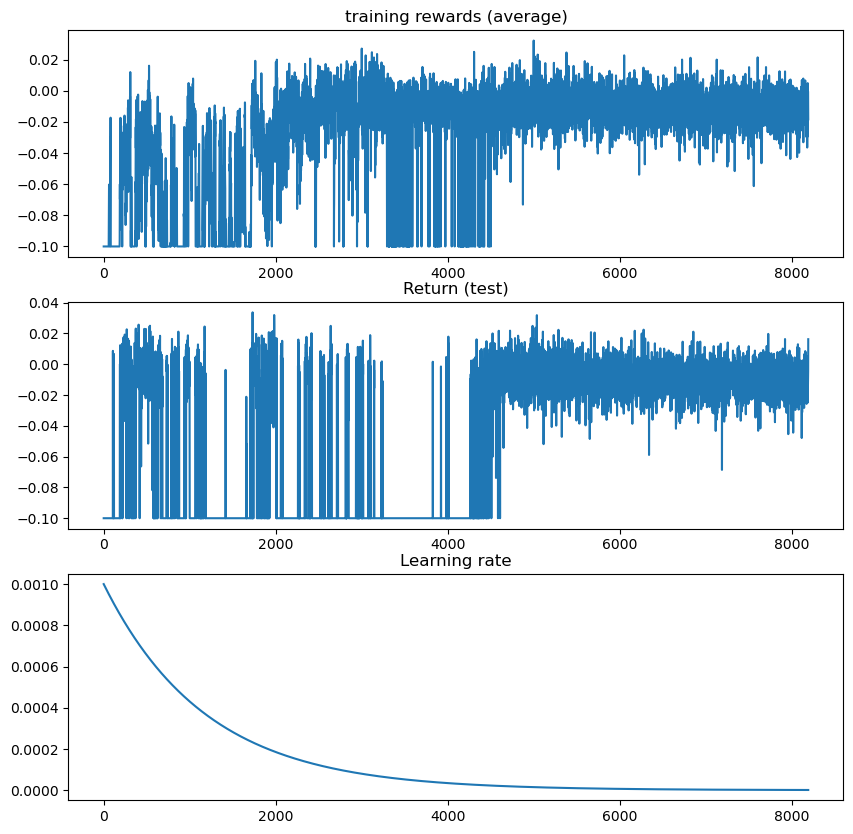

In [4]:
import matplotlib.pyplot as plt



plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(np.clip(logs["reward"], -0.1, None))
plt.title("training rewards (average)")
plt.subplot(3, 1, 2)
plt.plot(np.clip(logs["eval reward (sum)"], -0.1, None))
plt.title("Return (test)")
plt.subplot(3, 1, 3)
plt.plot(logs["lr"])
plt.title("Learning rate")
plt.show()

In [6]:
import numpy as np

max_runs = env.dates.shape[0] // env.batch_size[0]
total_reward = 0
max_reward = np.inf * -1
min_reward = np.inf

with set_exploration_type(ExplorationType.MODE), torch.no_grad():
    for iter_dl in range(max_runs):
        rollout = env.rollout(steps, actor)
        total_reward += rollout["next", "reward"].sum().item()
        max_reward = max(max_reward, rollout["next", "reward"].sum(1).max().item())
        min_reward = min(min_reward, rollout["next", "reward"].sum(1).min().item())

avg_reward = total_reward / (max_runs * env.batch_size[0])

avg_reward, max_reward, min_reward

(-0.011020033930026747, 0.337748259305954, -0.8369850516319275)

In [10]:
rollout = env.rollout(steps, actor)

In [20]:
iter_dl = rollout["next", "reward"].sum(1).argmax().item()

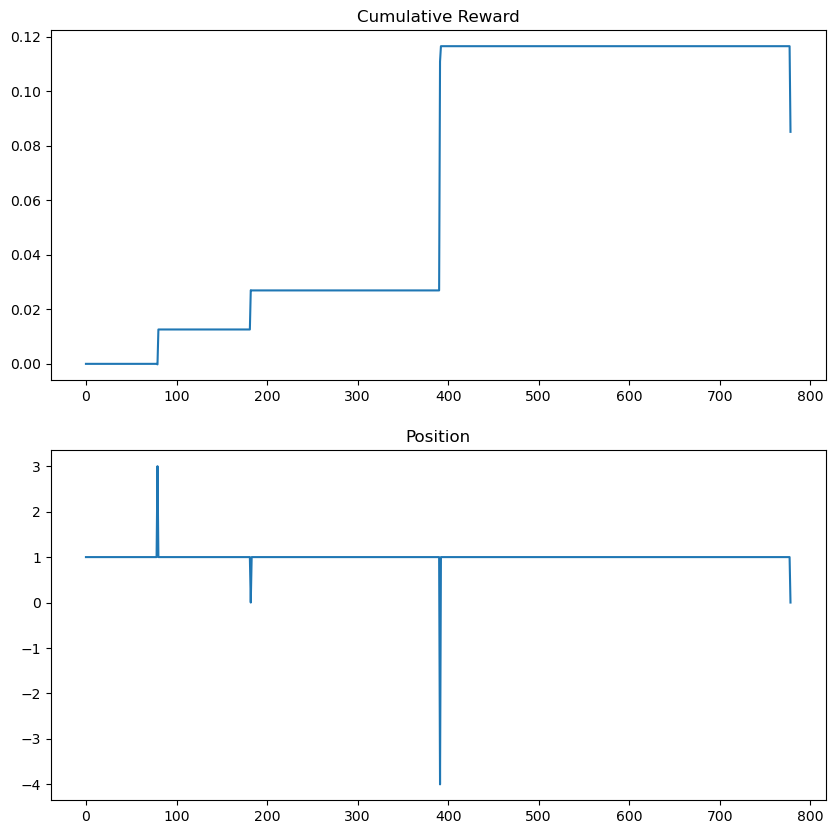

In [23]:
cumsum = rollout["next", "reward"][iter_dl].cumsum(0).cpu().numpy()
position = rollout["next", "position"][iter_dl].cpu().numpy() -5

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(cumsum)
plt.title("Cumulative Reward")
plt.subplot(2, 1, 2)
plt.plot(position)
plt.title("Position")
plt.show()


In [95]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import itertools

d = torch.arange(0, 20, device='cuda', dtype=torch.float32)

ds = TensorDataset(d)

dl = DataLoader(ds, batch_size=25, shuffle=True, drop_last=True)

# infinite_iterator = itertools.cycle(dl)

# for _ in range(20):
#     batch = next(infinite_iterator)
#     print(batch)

for d in enumerate(dl):
    print(d)



In [ ]:
time = torch.randint(3600, 82740, (10, 1000), device='cuda', dtype=torch.int64)
min_time = time.min(dim=1, keepdim=True)[0]
max_time = time.max(dim=1, keepdim=True)[0] + 60
time = (time - min_time) / (max_time - min_time)
time

In [341]:
import importlib
import ifera_n as ifera
import torch

from tqdm import tqdm
import time
import math
import numpy as np

from einops import rearrange, reduce, repeat

# import torch._dynamo
# torch._dynamo.config.suppress_errors = True

importlib.reload(ifera)

torch.cuda.empty_cache()

# Suppress pytorch warnings
import warnings
import datetime
warnings.filterwarnings("ignore")

device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
dtype = torch.float32

config = ifera.InstrumentConfig()
instrument = config.get_config("CL@IBKR:1m")

dates, main_data = ifera.load_instrument_data_tensor(instrument, dtype=dtype, device=device)

max_units = 5
n_positions = 2 * max_units + 1

start_time_idx = int((instrument.liquidStart - instrument.tradingStart - instrument.skipStartTime).total_seconds() / instrument.timeStep.total_seconds())
end_time_idx = int((instrument.liquidEnd - instrument.tradingStart - instrument.skipStartTime).total_seconds() / instrument.timeStep.total_seconds()) - 1
steps = end_time_idx - start_time_idx + 1

profit_tab = torch.zeros((main_data.shape[0], steps, n_positions, n_positions), device=device, dtype=dtype)
optimal_values = torch.full((main_data.shape[0], steps, n_positions), -np.inf, device=device, dtype=dtype)
worst_values = torch.full((main_data.shape[0], steps, n_positions), np.inf, device=device, dtype=dtype)
past_profit_best = torch.full((main_data.shape[0], steps, n_positions), -np.inf, device=device, dtype=dtype)
past_profit_worst = torch.full((main_data.shape[0], steps, n_positions), np.inf, device=device, dtype=dtype)

market_sim = ifera.MarketSimulatorIntraday(instrument = instrument, dates=dates, data=main_data)
date_idx = torch.arange(0, main_data.shape[0], device=device, dtype=torch.int64)
pos = torch.arange(-max_units, max_units + 1, device=device, dtype=torch.int32)
target_pos = torch.arange(-max_units, max_units + 1, device=device, dtype=torch.int32)

date_idx = repeat(date_idx, 'd -> d p1 p2', p1=n_positions, p2=n_positions)
pos = repeat(pos, 'p -> d p p2', d=date_idx.shape[0], p2=n_positions)
target_pos = repeat(target_pos, 'p2 -> d p p2', d=date_idx.shape[0], p=n_positions)
action = target_pos - pos

day_open_price = main_data[:, start_time_idx, 1]
margin_multiplier = instrument.margin / (instrument.contractMultiplier * instrument.referencePrice)
reference_capital = day_open_price * instrument.contractMultiplier * max_units #* margin_multiplier
reference_capital = repeat(reference_capital, 'd -> d p p2', p=n_positions, p2=n_positions)

# Pre-calculate all profits
for i in tqdm(range(steps)):
    profit, _ = market_sim.calculate_step(date_idx, i + start_time_idx, pos, action)
    profit = (profit / reference_capital)
    profit_tab[:, i, :, :] = profit

# Last time step, the action is fixed to 0 target_position (close all positions)
profit = profit_tab[:, -1, :, :]
profit = repeat(profit[:, :, max_units], 'd p -> d p p2', p=n_positions, p2=n_positions)
optimal_values[:, -1, :] = (profit).max(dim=2)[0]
worst_values[:, -1, :] = (profit).min(dim=2)[0]

# Loop backwards through the time steps
for i in tqdm(range(steps - 2, -1, -1)):
    profit = profit_tab[:, i, :, :]
    optimal_values[:, i, :] = (profit + optimal_values[date_idx, i + 1, target_pos + max_units]).max(dim=2)[0]
    worst_values[:, i, :] = (profit + worst_values[date_idx, i + 1, target_pos + max_units]).min(dim=2)[0]

past_profit_best[:, 0, :] = 0.0
past_profit_worst[:, 0, :] = 0.0

for i in tqdm(range(0, steps - 1)):
    profit = profit_tab[:, i, :, :]
    past_profit_best[:, i + 1, :] = (profit + past_profit_best[date_idx, i, pos + max_units]).max(dim=1)[0]
    past_profit_worst[:, i + 1, :] = (profit + past_profit_worst[date_idx, i, pos + max_units]).min(dim=1)[0]


Loading data/processed/futures/1m/CL.csv


100%|██████████| 779/779 [00:00<00:00, 3209.22it/s]


In [366]:
#optimal_values[1001, 501, :] + (market_sim.calculate_step(1000, 500, pos[1000, 5, :], action[1000, 5, :])[0] / reference_capital[1000, 5, :]).max(dim=2)[0]
d = 1001
((market_sim.calculate_step(d, 500 + start_time_idx, pos[d, 5, :], action[d, 5, :])[0] / reference_capital[d, 5, :]) + optimal_values[d, 501, :]).max() - optimal_values[d, 500, 5]
((market_sim.calculate_step(d, 500 + start_time_idx, pos[d, :, 5], action[d, :, 5])[0] / reference_capital[d, :, 5]) + past_profit_best[d, 500, :]).max() - past_profit_best[d, 501, 5]

#print(f"{optimal_values.numel() * optimal_values.element_size() * 11:,}")

#start_time_idx, end_time_idx, steps

torch.max(-(past_profit_worst + worst_values).min(), (past_profit_best + optimal_values).max())

profit_tab[:, :, :, :].shape

batch_size = 32
date_batch = torch.randint(0, profit.shape[0], (batch_size,), device=device, dtype=torch.int64)
time_batch = torch.randint(0, profit.shape[1], (batch_size,), device=device, dtype=torch.int64)
pos_batch = torch.randint(0, profit.shape[2], (batch_size,), device=device, dtype=torch.int64)

profit_batch = profit_tab[date_batch, time_batch, pos_batch, :]
target_pos_idx = repeat(torch.arange(0, n_positions, device=device, dtype=torch.int64), 'p -> b p', b=batch_size)
profit_batch + optimal_values[date_batch, time_batch + 1, :]

tensor([[0.1302, 0.1301, 0.1301, 0.1300, 0.1300, 0.1299, 0.1299, 0.1298, 0.1297,
         0.1297, 0.1295],
        [0.1103, 0.1103, 0.1104, 0.1104, 0.1104, 0.1106, 0.1106, 0.1106, 0.1104,
         0.1102, 0.1100],
        [0.1184, 0.1185, 0.1187, 0.1188, 0.1190, 0.1190, 0.1192, 0.1194, 0.1196,
         0.1196, 0.1196],
        [0.1294, 0.1293, 0.1293, 0.1292, 0.1292, 0.1294, 0.1297, 0.1296, 0.1296,
         0.1295, 0.1293],
        [0.1138, 0.1138, 0.1137, 0.1137, 0.1136, 0.1126, 0.1127, 0.1130, 0.1133,
         0.1135, 0.1137],
        [0.3670, 0.3669, 0.3667, 0.3666, 0.3665, 0.3660, 0.3666, 0.3666, 0.3666,
         0.3665, 0.3663],
        [0.1158, 0.1160, 0.1161, 0.1162, 0.1162, 0.1154, 0.1159, 0.1161, 0.1164,
         0.1166, 0.1169],
        [0.2208, 0.2205, 0.2203, 0.2200, 0.2198, 0.2195, 0.2190, 0.2187, 0.2184,
         0.2181, 0.2178],
        [0.1552, 0.1553, 0.1554, 0.1555, 0.1554, 0.1553, 0.1553, 0.1552, 0.1551,
         0.1551, 0.1550],
        [0.2180, 0.2180, 0.2181, 0.21

In [ ]:
(past_profit_best + optimal_values).max(dim=2)[0].min()

torch.unravel_index((past_profit_best + optimal_values).max(dim=2)[0].argmin(), optimal_values.shape[:2])

(past_profit_best +optimal_values)[1144].max(dim=1)[0]



#main_data[1145, start_time_idx:end_time_idx, 1].min(), main_data[1145, start_time_idx:end_time_idx, 1].max(), (main_data[1145, start_time_idx:end_time_idx, 5] == 0.0).sum()

In [146]:
(market_sim.calculate_step(1145, 0 + start_time_idx, pos[1145], action[1145])[0] / reference_capital).shape

torch.Size([3565, 11, 11])

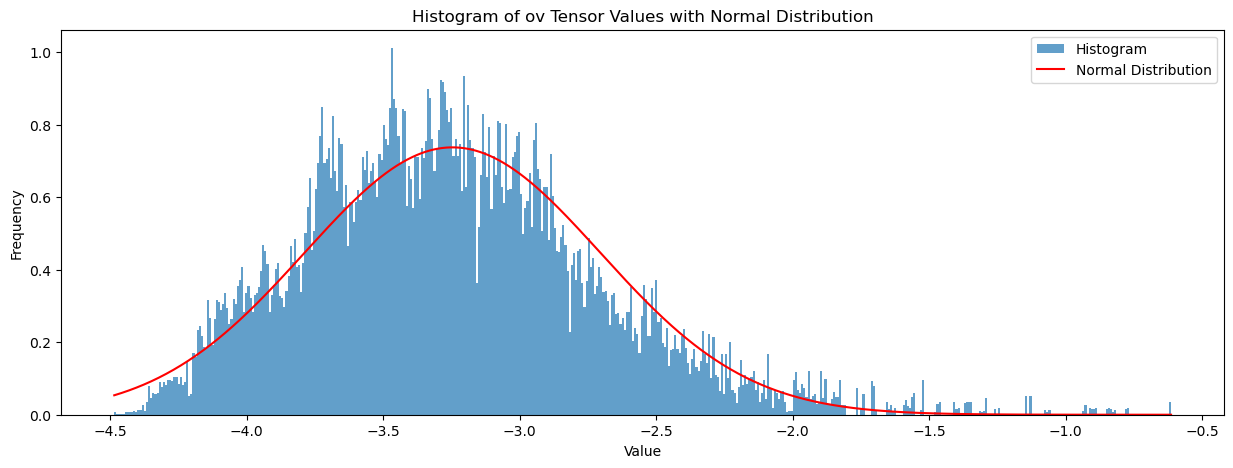

In [238]:
import datetime as dt

# optimal_values[1145, :, 5]

# main_data[1145, start_time_idx:end_time_idx, 4]

t = optimal_values.shape[1] //4

# optimal_values[:, t, :].min(), optimal_values[:, t, :].max(), optimal_values[:, t, :].mean(), optimal_values[:, t, :].std()

#optimal_values[:, 0, :].mean(), optimal_values[:, 0, :].std()

#ov = optimal_values[:, t, :]
ov = past_profit_best[:, t, :]

#ov = (ov - ov.mean()) / ov.std()

ov = (ov.flatten() + 0.01).log().cpu().numpy()
#ov = (ov.flatten()).cpu().numpy()

import matplotlib.pyplot as plt

# import scipy.stats as stats

ov_min = ov.min()
ov_max = ov.max()
ov_mean = ov.mean()
ov_std = ov.std()

x = np.linspace(ov_min, ov_max, 1000)
y = stats.norm.pdf(x, ov_mean, ov_std)

plt.figure(figsize=(15, 5))
plt.hist(ov, bins=500, density=True, alpha=0.7, label='Histogram')
plt.plot(x, y, 'r', label='Normal Distribution')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of ov Tensor Values with Normal Distribution')
plt.legend()
plt.show()

import scipy.stats as stats

# Fit a T-distribution to the ov data series
# df, loc, scale = stats.t.fit(ov)

# # Generate the T-distribution PDF
# x = np.linspace(ov_min, ov_max, 1000)
# y = stats.t.pdf(x, df, loc, scale)


# # Plot the histogram and T-distribution
# plt.figure(figsize=(15, 5))
# plt.hist(ov, bins=1000, density=True, alpha=0.7, label='Histogram')
# plt.plot(x, y, 'r', label='T-Distribution')

# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram of ov Tensor Values with T-Distribution')
# plt.legend()

# #plt.xlim(0, 1.0)

# plt.show()





In [56]:
torch.max(-worst_values.min(), optimal_values.max())


tensor(3.7992, device='cuda:0')

In [92]:
import datetime
path = ifera.make_path(True, instrument)
mtime = datetime.datetime.fromtimestamp(path.stat().st_mtime)
mtime
type(path.stat().st_mtime)


float

In [ ]:
import importlib
import ifera_n as ifera
import torch
import numpy as np
import pandas as pd
import datetime as dt

config = ifera.InstrumentConfig()
instrument = config.get_config("CL@IBKR:1m")
start_time_offset = instrument.tradingStart

df = ifera.load_data(raw=True, instrument=instrument)
df['trade_date'] = pd.to_datetime((df.index - start_time_offset).date)
rs = df.resample('30min')
df2 = rs[['volume']].sum()
df2['trade_date'] = pd.to_datetime((df2.index - start_time_offset).date)
df2 = df2[(df2.index.time <= dt.time(15, 30))|(df2.index.time >= dt.time(19, 00))]

rs2 = df2.resample('D', on='trade_date')
df3 = rs2[['volume', 'trade_date']].min()

df3[df3['volume'] == 0]
#df2[df2['trade_date'] == pd.to_datetime('2009-10-03')]


df3[(df3['volume'] == 0)&(df3['trade_date'].dt.dayofweek <= 4)]
df2[df2['trade_date'] == pd.to_datetime('2009-10-20')]

In [95]:
import importlib
import ifera_n as ifera
import torch
import numpy as np
import pandas as pd
import datetime as dt
import copy

importlib.reload(ifera)

pd.set_option('display.width', 160)

config = ifera.InstrumentConfig()
instrument = config.get_config("CL@IBKR:1m")

# time_step = instrument.timeStep
# start_time_offset = instrument.tradingStart
# start_time = instrument.skipStartTime
# end_time = instrument.endTime
# total_steps = instrument.totalSteps
# offset_seconds = start_time_offset.total_seconds()

# df = ifera.load_data(raw=True, instrument=instrument, dtype="float64")

# df['date'] =  pd.to_datetime(df.index.date)
# df['time'] =  pd.to_timedelta(df.index.hour * 3600 + df.index.minute * 60 + df.index.second, unit='s')

# df['offset_time'] = df['time'] - start_time_offset
# df['offset_time'] = df['offset_time'].apply(lambda x: x - pd.to_timedelta(x.days, unit='d'))

# df['trade_date'] = pd.to_datetime((df.index - start_time_offset).date)

path = ifera.make_path(raw=False, instrument=instrument, special_interval="fulldays")

instrument30min = copy.deepcopy(instrument)
instrument30min.interval = "30m"
instrument30min.__post_init__()
time_steps_seconds = instrument30min.timeStep.total_seconds()

df = ifera.load_data(raw=True, instrument=instrument30min)

df['time'] = pd.to_timedelta(df.index.hour * 3600 + df.index.minute * 60 + df.index.second, unit='s')

start_time_offset = instrument30min.tradingStart
start_time = instrument30min.skipStartTime
end_time = instrument30min.liquidEnd - instrument30min.tradingStart - instrument30min.timeStep

df['trade_date'] = pd.to_datetime((df.index - start_time_offset).date)
df['offset_time'] = df['time'] - start_time_offset
df['offset_time'] = df['offset_time'].apply(lambda x: x - pd.to_timedelta(x.days, unit='d'))

df = df[(df['offset_time'] >= start_time) & (df['offset_time'] <= end_time)]

dates = df.groupby('trade_date').agg({'offset_time': ['count']})
max_steps = int((end_time - start_time).total_seconds() / time_steps_seconds) + 1

short_days = dates[(dates['offset_time']['count'] < max_steps)]
full_days = dates.drop(short_days.index, errors='ignore').reset_index()[['trade_date']]
short_days = short_days.reset_index()


In [94]:
config = ifera.InstrumentConfig()
instrument = config.get_config("CL@IBKR:1m")



ifera_n.InstrumentData

In [378]:
import datetime as dt
loss_matrix = optimal_values[:, :-1, :].max(dim=-1, keepdim=True)[0] - optimal_values[:, :-1, :]

loss_matrix = loss_matrix / loss_matrix.std()

loss_matrix.min(), loss_matrix.max(), loss_matrix.mean(), loss_matrix.std(), (loss_matrix > (loss_matrix.std() * 20 + loss_matrix.mean())).sum(), loss_matrix.numel()

# loss_square = (loss_matrix + 1.0).pow(2) - 1.0
# loss_square = loss_square / loss_square.std()

# loss_square.min(), loss_square.max(), loss_square.mean(), loss_square.std(), (loss_square > (loss_square.std() * 20 + loss_square.mean())).sum(), loss_square.numel()

# zero_vol = (main_data[:, start_time_idx+1:end_time_idx, 5] == 0.0)
# loss_matrix2 = loss_matrix.clone().detach()
# loss_matrix2[~zero_vol] = 0.0

# lm = torch.unravel_index(loss_matrix2.argmax(), loss_matrix2.shape)

# dt.date.fromordinal(dates[lm[0]]), dt.timedelta(minutes=lm[1].item()) + instrument.liquidStart, loss_matrix2.max(), (loss_matrix > loss_matrix2.max()).sum()

# p = loss_matrix.max(dim=-1)[0].max(dim=-1)[0].sort(descending=True)[0].cpu()
# p = loss_matrix.flatten()
# import matplotlib.pyplot as plt

# #non_zero_p = (p[p != 0.0] + 0.01).log().cpu()
# non_zero_p = p[p != 0.0].cpu()

# plt.hist(non_zero_p, bins=1000)
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('Histogram of p (non-zero values)')
# plt.show()



(tensor(0., device='cuda:0'),
 tensor(155.6712, device='cuda:0'),
 tensor(0.9956, device='cuda:0'),
 tensor(1., device='cuda:0'),
 tensor(1547, device='cuda:0'),
 30548485)

In [377]:
print("{:,}".format(p.numel() * p.element_size()))


122,193,940


4

In [186]:
(main_data[:, :, 5] == 0.0).any(dim=1).sum()

zero_vol = (main_data[:, start_time_idx+1:end_time_idx, 5] == 0.0)

print(zero_vol[:, 0:10].sum(dim=0))

# Shift zero_vol by 1 on dim 1 to get the previous time step
zero_vol = zero_vol.roll(shifts=-1, dims=1)

zero_vol.shape


tensor([1, 5, 0, 7, 8, 4, 7, 4, 7, 4], device='cuda:0')


torch.Size([3566, 778])

In [152]:
import importlib
import ifera_n as ifera
import datetime as dt
import pathlib as pl

importlib.reload(ifera)

config = ifera.InstrumentConfig()
instrument = config.get_config("CL@IBKR:1m")

path = ifera.make_path(raw=False, instrument=instrument)
last_update = path.stat().st_mtime
raw_path = ifera.make_path(raw=True, instrument=instrument)

last_update, raw_path.stat().st_mtime, instrument.last_update, last_update < raw_path.stat().st_mtime or last_update < instrument.last_update

# (dates, data) = ifera.load_instrument_data_tensor(instrument, dtype=torch.float32, device=torch.device("cuda"))

# dates
# columns = ["date", "time", "open", "high", "low", "close", "volume"]
# dtype = {"open": dtype, "high": dtype, "low": dtype, "close": dtype, "volume": "int32"}
# df = pd.read_csv(raw_path, header=None, parse_dates=False, names=columns, dtype=dtype)

(1708077438.1510153, 1707199865.581015, 1708077509.9310153, True)

In [157]:
import importlib
import ifera_n as ifera
import datetime as dt
import pathlib as pl

importlib.reload(ifera)

config = ifera.InstrumentConfig()
instrument = config.get_config("CL@IBKR:1m")

(dates, data) = ifera.load_instrument_data_tensor(instrument, dtype=torch.float32, device=torch.device("cuda"))

#(dates == dt.date(2020, 4, 2).toordinal()).any()



Loading data/processed/futures/1m/CL.csv
Loading data/raw/futures/1m/CL.csv
Loading data/raw/futures/30m/CL.csv
Removed 1 rows from CL due to removeDates


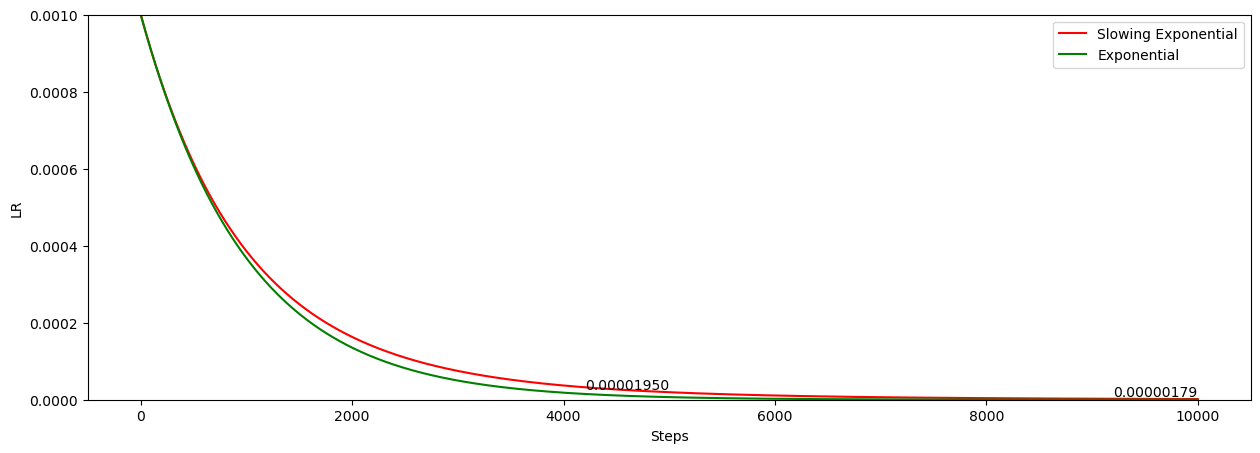

51.20409830163164 10.878170735791247 557.3449958810169
148.63611943461487 148.6361194346149 22114.810811392494
[1.0] [2.903960032419543] [39.678854165425406]


In [338]:
x = np.linspace(1, 10000, 10000)

s = 0.001
t = 1 - 10.0 / len(x)
q = 1 - (1 - t) / 10.0

y = np.power(0.999, x) * s
y2 = np.power(t, x) * s

for i in range(1, len(x)):
    y[i] = y[i-1] * t
    t = 1.0 - (1.0 - t) * q
plt.figure(figsize=(15, 5))
plt.plot(x, y, 'r', label='Slowing Exponential')
plt.plot(x, y2, 'g', label='Exponential')

plt.xlabel('Steps')
plt.ylabel('LR')
plt.legend()

# Label the last value
last_value = y[-1]
plt.text(x[-1], last_value, f'{last_value:.8f}', ha='right', va='bottom')
plt.text(x[5000], y[5000], f'{y[5000]:.8f}', ha='right', va='bottom')

# Set the Y range to [0,1]
plt.ylim(0, 0.001)

plt.show()

print(y[0] / y[len(x)//2-1], y[len(x)//2] / y[-1], y[0] / y[-1])
print(y2[0] / y2[len(x)//2-1], y2[len(x)//2] / y2[-1], y2[0] / y2[-1])
print([y[0] / y2[0]], [y[len(x)//2] / y2[len(x)//2]], [y[-1] / y2[-1]])

In [1]:
import importlib
import ifera_n as ifera
import torch
import numpy as np
import pandas as pd
import datetime as dt

importlib.reload(ifera)

import os
import time

os.environ['TORCH_LOGS'] = "+dynamo"
os.environ['TORCHDYNAMO_VERBOSE'] = "1"

torch.set_float32_matmul_precision('high')

config = ifera.InstrumentConfig()
instrument = config.get_config("CL@IBKR:1m")

device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
dtype = torch.float32

dates, main_data = ifera.load_instrument_data_tensor(instrument, dtype=dtype, device=device)

market_sim = ifera.MarketSimulatorIntraday(instrument = instrument, dates=dates, data=main_data)
env = ifera.IntradayEnv(market_sim=market_sim, batch_size=(32,), window_size=60, start_time_idx=0, max_units=5)

actornet_hidden = ifera.ActorNetHidden(128, device=device, dtype=dtype)
actor_net = ifera.ActorNet(env, 32, actornet_hidden, dist_return='mode')

start_time = time.time()
rewards = env.rollout_all(actor_net, env.steps + 1)
print(f"Execution time: {time.time() - start_time} seconds")

start_time = time.time()
rewards = env.rollout_all(actor_net, env.steps + 1)
print(f"Execution time: {time.time() - start_time} seconds")

rewards

Loading data/processed/futures/1m/CL.csv


/home/gabor/anaconda3/envs/torch2/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Execution time: 111.09648633003235 seconds
Execution time: 118.24081683158875 seconds


tensor([-0.0103,  0.0022, -0.0269,  ...,  0.0111,  0.0135,  0.0136])

In [2]:


sortino = (rewards.mean() + 1.0) / (rewards[rewards < 0.0].std() + 1.0) - 1.0

rewards.min(), rewards.max(), rewards.mean(), rewards.std(), sortino

(tensor(-0.0859),
 tensor(0.0879),
 tensor(-0.0005),
 tensor(0.0120),
 tensor(-0.0088))

In [4]:
torch.cuda.is_available()

False

In [2]:
import torch
from torch.distributions import Categorical

t = torch.rand((10, 3), device='cuda', dtype=torch.float32)

dist = Categorical(logits=t)

dist.mode

tensor([1, 0, 1, 1, 0, 2, 0, 0, 0, 1], device='cuda:0')